# Filtering and resampling Xarray datasets with xbatcher

There are many cases in machine learning where we want to discard invalid observations or modify the distribution of a target variable. This notebook demonstrates how `BatchGenerators` can be used to make filtered or resampled datasets by passing functions that identify usable data or assign a sample weight to each patch.

### Libraries and toy data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xbatcher as xb

In [2]:
ds = xr.tutorial.open_dataset('air_temperature')
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### Filtering

Here we add a QA variable to the air temperature dataset. Suppose that 1% of the time there is an instrument failure, and we do not want any cells with the QA flag set to go into a model.

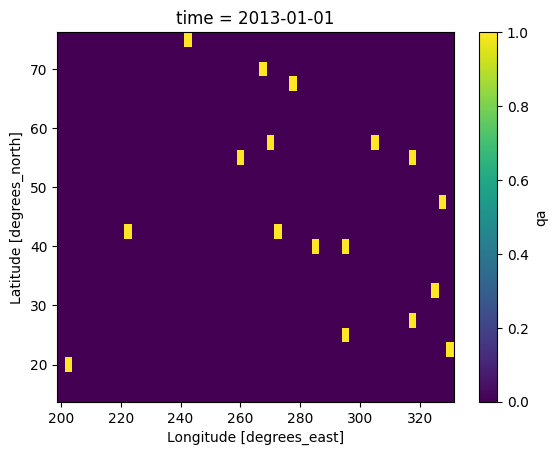

In [3]:
ds['qa'] = (('time', 'lat', 'lon'), np.random.rand(*ds.air.shape) < 0.01)
ds['qa'].isel(time=0).plot()

Define a small function to determine which patches to keep. The function should take the underlying dataset as its first argument, and a dictionary of slice objects as the second argument. Each dictionary corresponds to one batch from the `BatchGenerator`. Batches for which the function returns True are retained in the `BatchGenerator`.

In [4]:
def myfilter(ds, batch):
    return (ds.isel(**batch).qa == 0).all()

Now we pass the filter function to the batch generator and verify that none of the anomalous pixels make it into resulting batches.

In [5]:
bgen_original = xb.BatchGenerator(ds, {'lat': 5, 'lon': 5, 'time': 5})

bgen_filtered = xb.BatchGenerator(
    ds, {'lat': 5, 'lon': 5, 'time': 5}, filter_fn=myfilter
)

print('Original generator:', len(bgen_original), 'batches')
print('Filtered generator:', len(bgen_filtered), 'batches')

for batch in bgen_filtered:
    assert (batch.qa == 0).all()

Original generator: 29200 batches
Filtered generator: 8344 batches


### Resampling

Now we show how to resample a `BatchGenerator`. Note that this approach only supports *undersampling*. That is, you can only remove batches, not duplicate them. Now our task is to define a function with the same signature as the filter, but this time returning a non-negative float that indicates the relative sample weight of this patch. This functionality uses `np.random.choice` to select batches, so use `np.random.seed` to ensure reproducibility.

Suppose we want to sample the dataset to emphasize batches with low air temperature. One option is to return a higher sample weight for batches with mean air temperature below a certain threshold.

In [6]:
threshold = 270


def myresample(ds, batch):
    window_mean = ds.isel(**batch).air.mean()
    if window_mean > threshold:
        return 1
    else:
        return 4


bgen_resampled = xb.BatchGenerator(
    ds, {'lat': 5, 'lon': 5, 'time': 5}, resample_fn=myresample, resample_n=5_000
)

Now, we can compare the distribution of batch mean air temperature between the resampled and original generator.

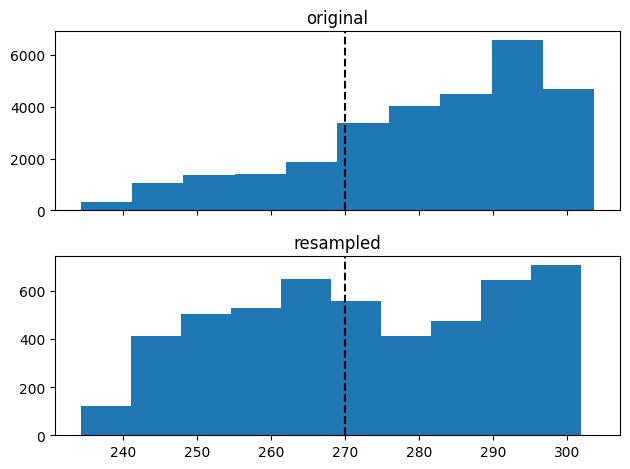

In [7]:
original_mean = np.array([batch.air.mean() for batch in bgen_original])
filtered_mean = np.array([batch.air.mean() for batch in bgen_resampled])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

line = dict(x=threshold, color='black', linestyle='dashed')

ax1.hist(original_mean)
ax1.axvline(**line)
ax1.set_title('original')
ax2.hist(filtered_mean)
ax2.axvline(**line)
ax2.set_title('resampled')
plt.tight_layout()
plt.show()